In [490]:
import torch
import warnings
import numpy as np
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt

from IPython.display import Video
from typing import Dict, List, Tuple

warnings.filterwarnings("ignore")
plt.style.use(['science', 'no-latex', 'ieee'])
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'figure.dpi': '100'})

Utils

In [501]:
def map_dataframe_columns(prefix_to_entropy_mappings: Dict[str, float], df: pd.DataFrame) -> pd.DataFrame:
    # delete min/max stat
    _df = df.loc[:,~df.columns.str.contains('MIN|MAX')].copy()
    _df.rename(columns={'MIN': 'min', 'MAX': 'max'}, inplace=True)
    # get suffix
    suf = list(_df.columns)[1].split(' ')[-1]
    formatted_columns_dict = dict(map(lambda x: (x[0] +' - '+ suf, 'beta_' + str(x[1]).replace('.', '_')) , prefix_to_entropy_mappings))
    _df.rename(columns=formatted_columns_dict, inplace=True)
    return _df
def map_dataframes(prefix_to_entropy_mappings: dict[str, float], dfs: list[pd.DataFrame]) -> tuple[pd.DataFrame]:
    mapped_dfs = []
    for df_idx, df in enumerate(dfs):
        mapped_dfs.append(map_dataframe_columns(prefix_to_entropy_mappings, df))
    return tuple(mapped_dfs)

### Reinforce with baseline

В работе рассматриваются работы алгоритмов REINFORCE with Baseline. Реализации алгоритмов

**Реализации алгоритмов**

Можно найти в папке `scripts`


#### Сетапы экспериментов

Политики для всех трех алгоритмов обучались $1500$ эпизодов. Начальный шаг оптимизации $lr=1e-2$, уменьшение шага осуществлялось при помощи $CosineAnnealingLR$ ($\eta_{min}=1e-5$, $T_{max} = 2000$), фактор дисконтирования $\gamma=0.99$, коэффициенты энтропийной регуляризации $\beta \in [0.0, 0.001, 0.01, 0.1, 1]$. Для обучения были выделены $\text{seeds}_{train} \in [0, 199]$, зацикленные до количества эпизодов, для валидации $\text{seeds}_{eval} \in [10.000, 10.099]$

Сама политика - это двухслойная нейронная сеть с размером скрытого состояния $h=128$, и дропаутом между слоями с $p_{dropout}=0.6$, имеющая $4$ входа (observation space dimension) и $2$ выхода (action space dimension).

В качестве среды для обучения был выбран `Cart-Pole-v1` из пакета `gymnasium`. Для успешно обучения порог успешного прохождения экспериментов был сдвинут до $1000$ шагов. Для валидации до $700$ шагов.

Для политики, обучаемой вместе с `ValueNetwork` были выставлены $lr=1e-2$, уменьшение шага осуществлялось при помощи $CosineAnnealingLR$ ($\eta_{min}=1e-5$, $T_{max} = 2000$)

###  $\text{REINFORCE}$ with Average Reward Baseline

In [400]:
average_reward_df_paths = [
    '../data/average_reward/eval_entropy.csv',
    '../data/average_reward/eval_reward.csv',
    '../data/average_reward/eval_min_reward.csv',
    '../data/average_reward/train_entropy.csv',
    '../data/average_reward/train_reward.csv',
]

average_reward_dfs = list(map(lambda path: pd.read_csv(path), average_reward_df_paths))

average_rewards_prefixes = [
    ('cart-pole-average-reward-baseline-2025-03-10-10-16-06', 0),
    ('cart-pole-average-reward-baseline-2025-03-10-11-56-17', 0.001),
    ('cart-pole-average-reward-baseline-2025-03-10-13-05-59', 0.01),
    ('cart-pole-average-reward-baseline-2025-03-10-13-56-33', 0.1),
    ('cart-pole-average-reward-baseline-2025-03-10-15-36-09', 1.0),
]

(avrb_eval_entropy,
 avrb_eval_min_episode_reward,
 avrb_eval_reward,
 avrb_train_entropy,
 avrb_train_reward) = map_dataframes(average_rewards_prefixes, average_reward_dfs)

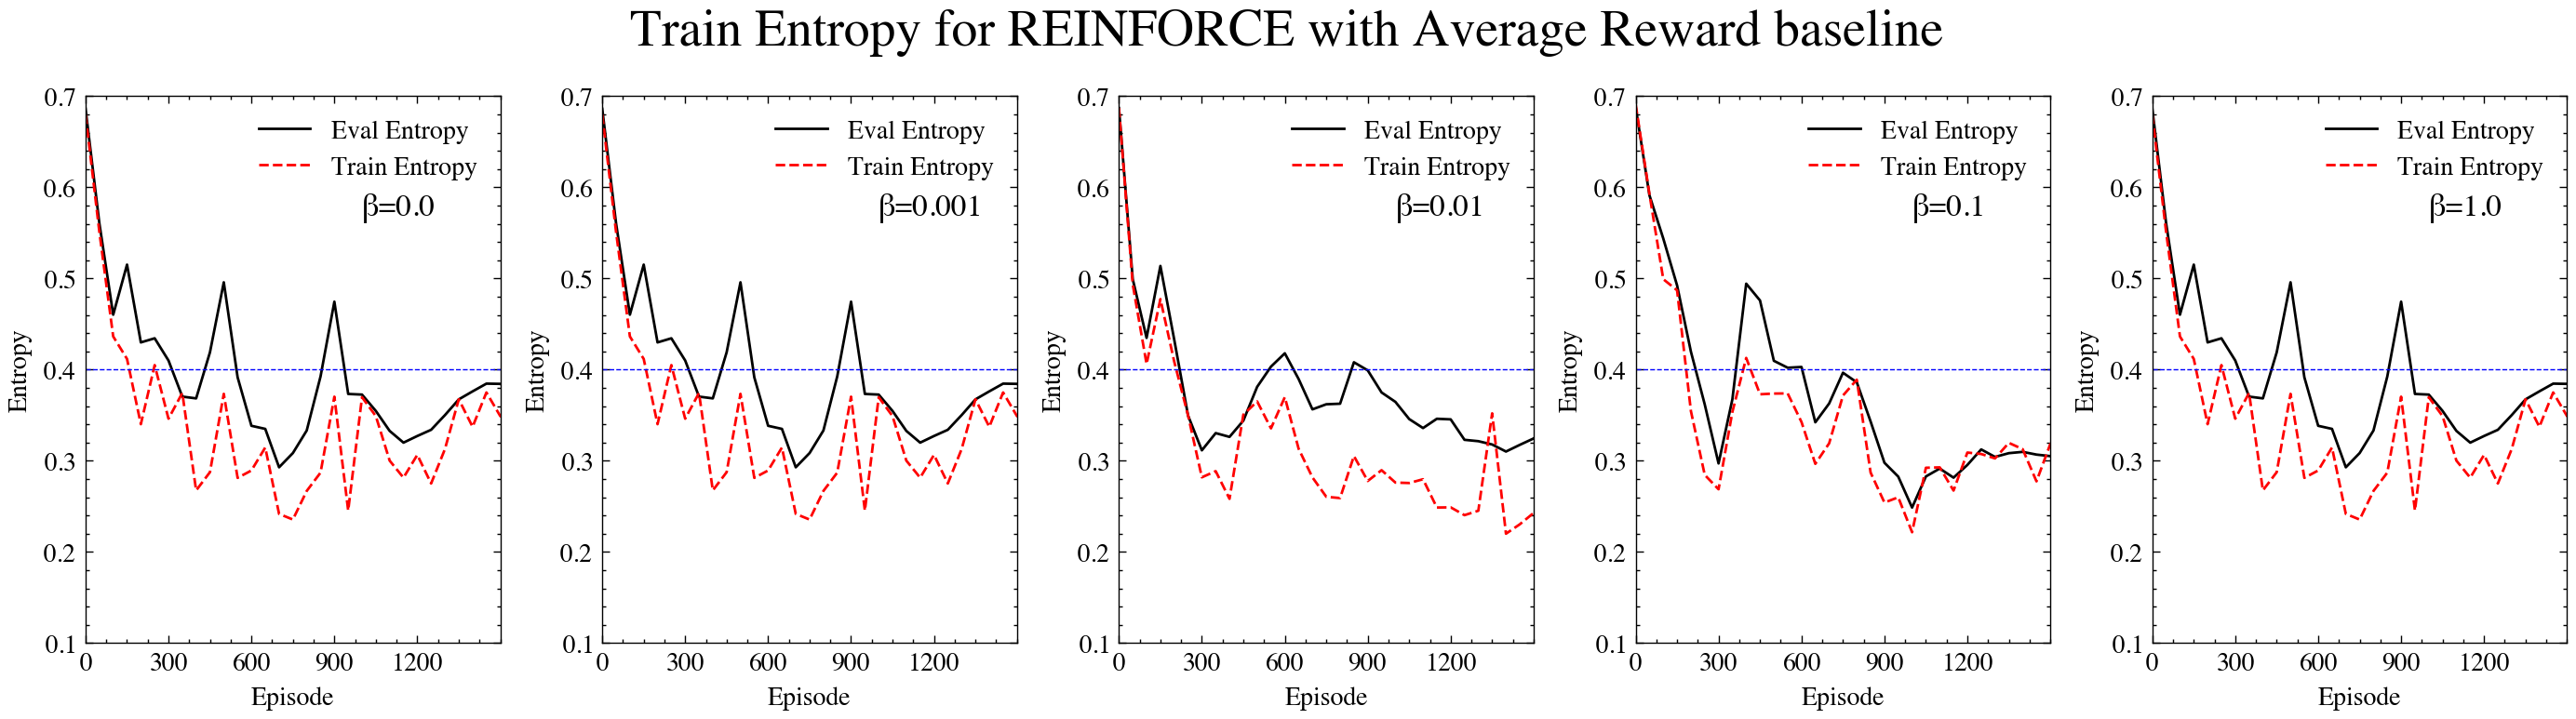

In [495]:
def draw_average_reward_entropy_plots(train_entropy: pd.DataFrame, eval_entropy: pd.DataFrame, title: str):

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,4))
    fig.suptitle(title, fontsize = 20)
    axs = axs.flatten()
    entropy_columns = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']
    for entropy_coef, ax, beta in zip(entropy_columns, axs, betas):
        eval_steps, eval_values = eval_entropy['Step'], eval_entropy[entropy_coef]

        selected_train_entropy = train_entropy[train_entropy['Step'].isin(eval_steps)]
        train_steps, train_values = selected_train_entropy['Step'], selected_train_entropy[entropy_coef]

        ax.plot(eval_steps, eval_values, label='Eval Entropy')
        ax.plot(train_steps, train_values, label='Train Entropy')
        ax.axhline(y=0.4, color='blue', linestyle='--', linewidth=0.5)

        ax.set_xlabel('Episode', fontsize=10)
        ax.set_ylabel('Entropy', fontsize=10)

        ax.set_ylim([0.1, 0.7])
        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=8)

        ax.legend(prop={'size': 10})
        ax.text(1000, 0.57, f'β={beta}', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    fig.show()
draw_average_reward_entropy_plots(avrb_train_entropy, avrb_eval_entropy, 'Train Entropy for REINFORCE with Average Reward baseline')

Энтропия политики $\pi_{\theta}$ уменьшается с каждым эпизодом. Это означает, что агент обучается правильным образом, соблюдая exploration–exploitation баланс. Действия агента становятся более уверенными с течением времени. Для $\beta=0.1$ удалось получить самое низкое значение энтропии. Однако, как можно видеть ниже на графиках наград за эпизоды само по себе обучение было очень нестабильным.

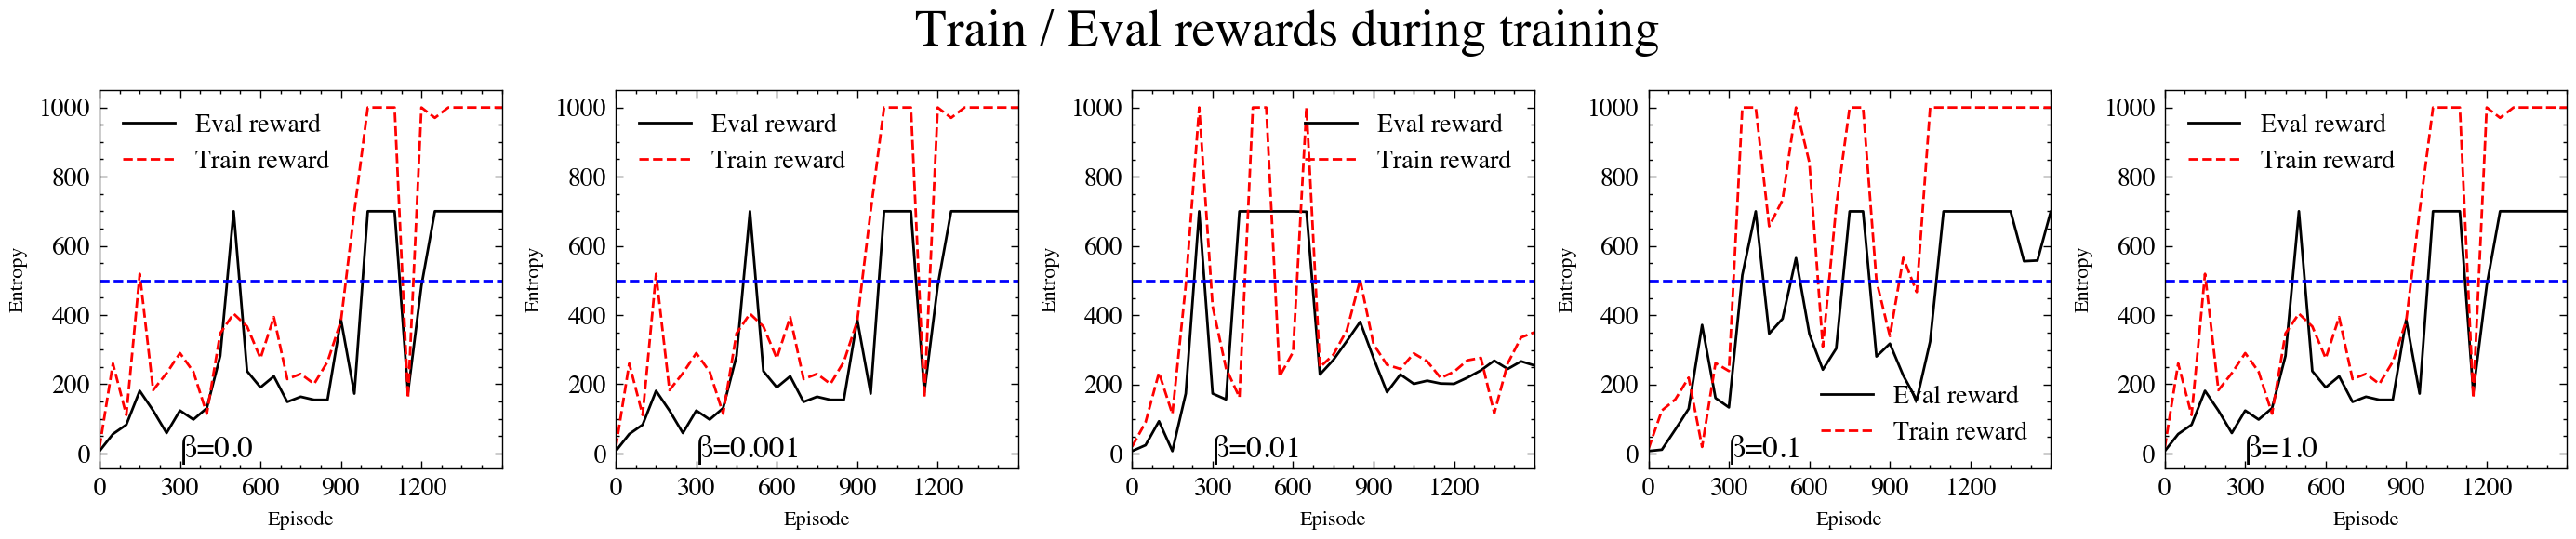

In [529]:
def draw_average_reward_baseline_reward():

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,3))
    fig.suptitle('Train / Eval rewards during training', fontsize = 20)
    axs = axs.flatten()
    axs = axs.flatten()

    entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

    for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
        eval_reward_steps, eval_reward_values = avrb_eval_reward['Step'], avrb_eval_reward[entropy_coef]

        train_reward_steps, train_reward_values = avrb_train_reward[avrb_train_reward['Step'].isin(eval_reward_steps)]['Step'], avrb_train_reward[avrb_train_reward['Step'].isin(eval_reward_steps)][entropy_coef]

        ax.plot(eval_reward_steps, eval_reward_values, label='Eval reward')
        ax.plot(train_reward_steps, train_reward_values, label='Train reward')
        ax.axhline(y=500, color='blue', linestyle='--', linewidth=1)

        ax.set_xlabel('Episode', fontsize=8)
        ax.set_ylabel('Entropy', fontsize=8)

        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.legend(prop={'size': 10})
        # ax.grid(True)
        ax.text(300, -10, f'β={beta}', fontsize=12)



    plt.tight_layout()
    plt.show()
draw_average_reward_baseline_reward()

Модель эпизодически влетала в оптимумы, но вскоре теряла в качестве. Значение награды стабилизируется на большой дистанции спустя $1000$ эпизодов при заданных параметрах эксперимента.

### $\text{REINFORCE}$ with Value-Function Baseline

In [503]:
vf_df_paths = [
    '../data/value_function/train_reward.csv',
    '../data/value_function/train_entropy.csv',
    '../data/value_function/eval_entropy.csv',
    '../data/value_function/eval_reward.csv',
    '../data/value_function/eval_min_reward.csv'
]

vf_dfs = list(map(lambda path: pd.read_csv(path), vf_df_paths))

value_function_prefixes = [
    ('cart-pole-value_function-reward-baseline-2025-03-11-18-35-47', 0.1),
    ('cart-pole-value_function-reward-baseline-2025-03-10-15-38-32', 1.0),
    ('cart-pole-value_function-reward-baseline-2025-03-10-14-03-52', 0.01),
    ('cart-pole-value_function-reward-baseline-2025-03-10-11-55-39', 0.001),
    ('cart-pole-value_function-reward-baseline-2025-03-10-09-02-33', 0),
]

(vf_train_reward,
 vf_train_entropy,
 vf_eval_entropy,
 vf_eval_reward,
 vf_eval_min_reward) =  map_dataframes(value_function_prefixes, vf_dfs)

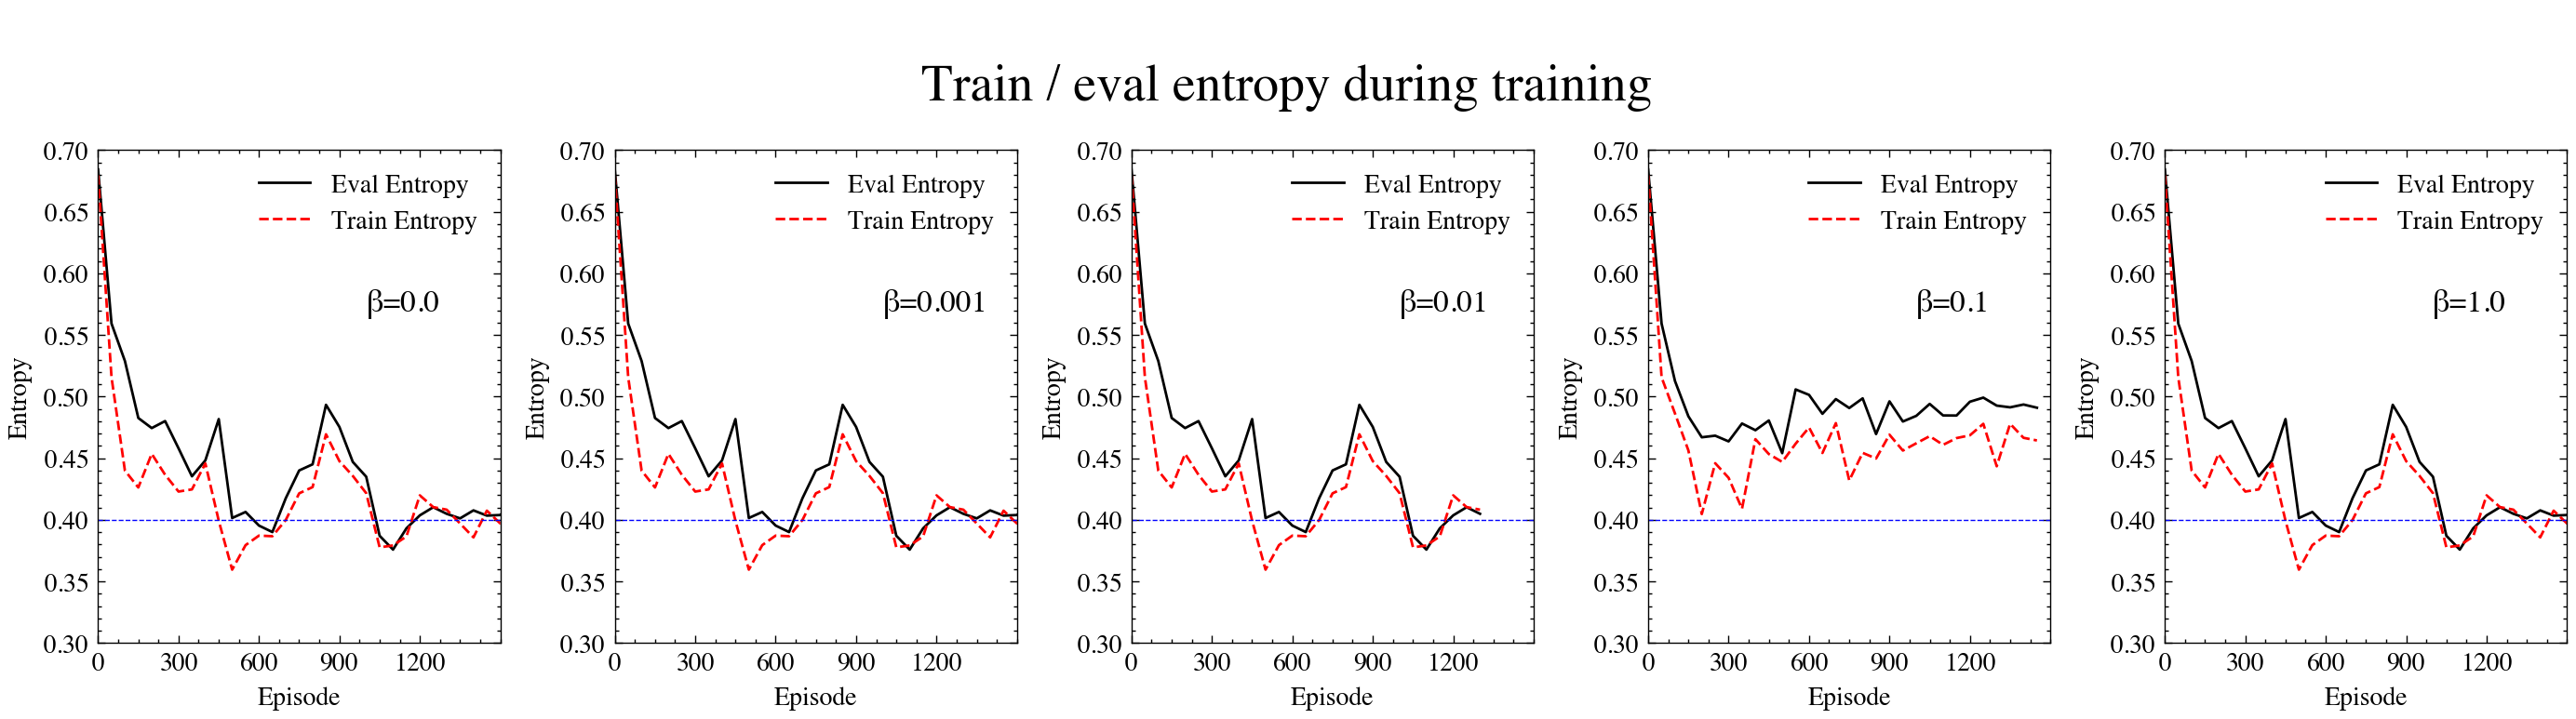

In [505]:
def show_value_function_baseline_entropy():
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,4))
    fig.suptitle('\nTrain / eval entropy during training', fontsize = 20)
    axs = axs.flatten()

    entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

    for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
        eval_entropy_steps, eval_entropy_values = vf_eval_entropy['Step'], vf_eval_entropy[entropy_coef]
        train_entropy_steps, train_entropy_values = vf_train_entropy[vf_train_entropy['Step'].isin(eval_entropy_steps)]['Step'], vf_train_entropy[vf_train_entropy['Step'].isin(eval_entropy_steps)][entropy_coef]

        ax.plot(eval_entropy_steps, eval_entropy_values, label='Eval Entropy')
        ax.plot(train_entropy_steps, train_entropy_values, label='Train Entropy')
        ax.axhline(y=0.4, color='blue', linestyle='--', linewidth=0.5)

        ax.set_xlabel('Episode', fontsize=10)
        ax.set_ylabel('Entropy', fontsize=10)

        ax.set_ylim([0.3, 0.7])
        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=8)

        ax.legend(prop={'size': 10})
        # ax.grid(True)
        ax.text(1000, 0.57, f'β={beta}', fontsize=12)

        ax.tick_params(axis='both', which='major', labelsize=10)



    plt.tight_layout()
    plt.show()
show_value_function_baseline_entropy()

Энтропия политики тут $\pi_{\theta}$ также уменьшается с каждым эпизодом. Это означает, что агент обучается правильным образом, соблюдая exploration–exploitation баланс. Действия агента становятся более уверенными с течением времени. На графиках также видно, что разные коэффициенты $\beta$ энтропийной регуляризации влияют уверенность ответов модели на больших горизонтах. Однако существенные различия в значениях энтропии имеет только один сетап против всех остальных, в котором коэффициент $\beta={0.1}$, в остальных случаях поведение энтропии почти идентично.

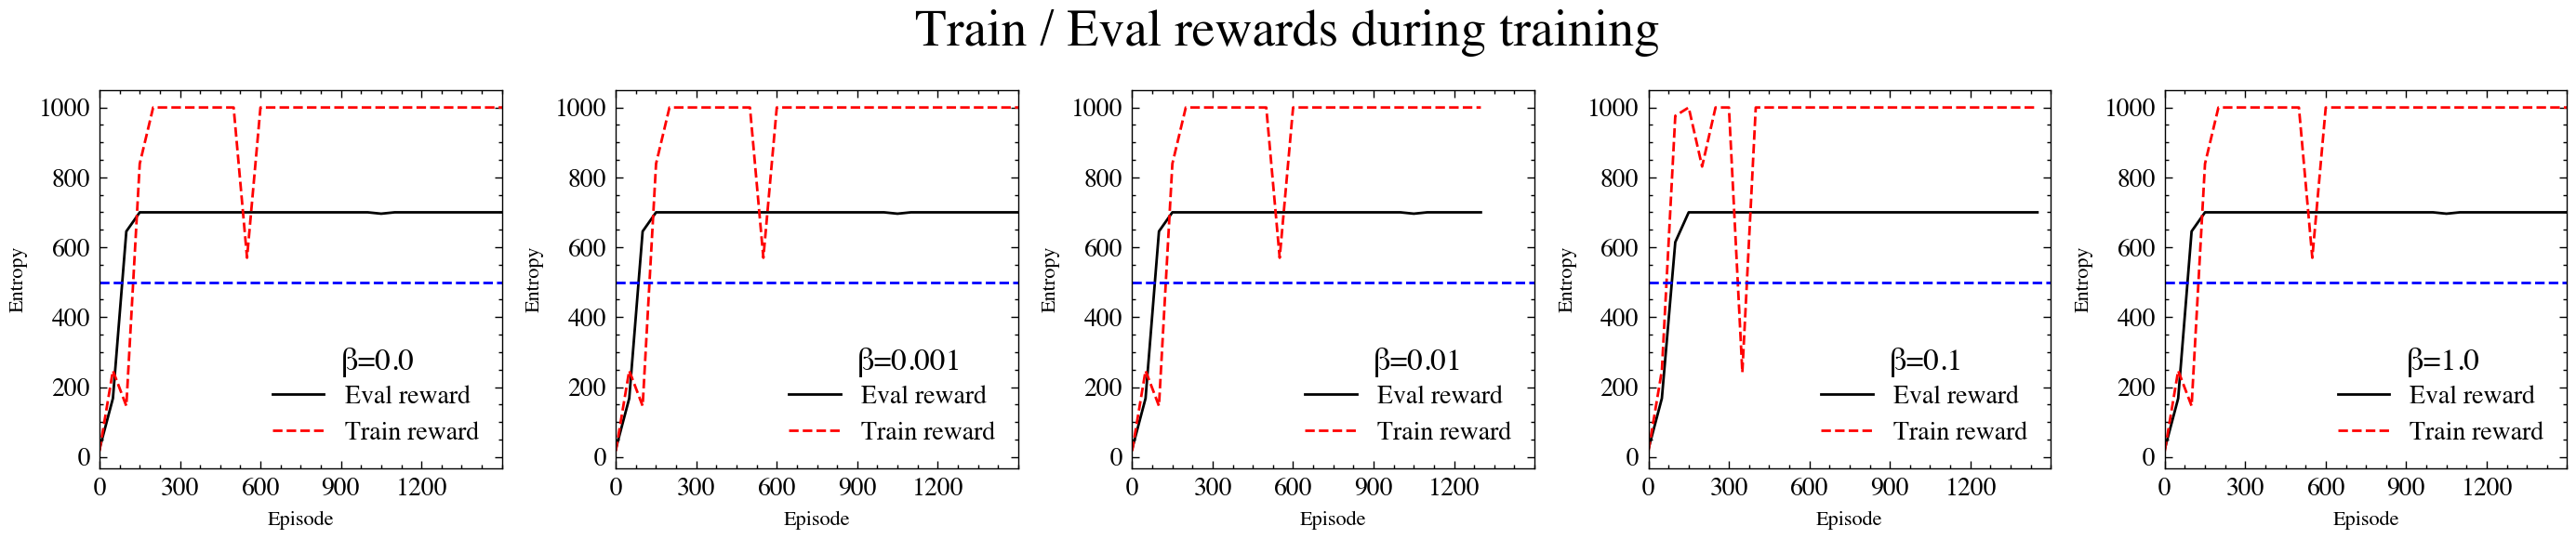

In [506]:
def draw_value_function_baseline_reward():

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,3))
    fig.suptitle('Train / Eval rewards during training', fontsize = 20)
    axs = axs.flatten()
    axs = axs.flatten()

    entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

    for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
        eval_reward_steps, eval_reward_values = vf_eval_reward['Step'], vf_eval_reward[entropy_coef]
        train_reward_steps, train_reward_values = vf_train_reward[vf_train_reward['Step'].isin(eval_reward_steps)]['Step'], vf_train_reward[vf_train_reward['Step'].isin(eval_reward_steps)][entropy_coef]

        ax.plot(eval_reward_steps, eval_reward_values, label='Eval reward')
        ax.plot(train_reward_steps, train_reward_values, label='Train reward')
        ax.axhline(y=500, color='blue', linestyle='--', linewidth=1)

        ax.set_xlabel('Episode', fontsize=8)
        ax.set_ylabel('Entropy', fontsize=8)

        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.legend(prop={'size': 10}, loc='lower right')
        # ax.grid(True)
        ax.text(900, 250, f'β={beta}', fontsize=12)



    plt.tight_layout()
    plt.show()
draw_value_function_baseline_reward()

Политики обученные $\text{REINFORCE}$ методом с value-function бейзлайном почти во всех случая сходятся к максимальному порогу награды примерно за $200$ эпизодов. При этом величина коэффициента энтропийной регуляризации $\beta$ в данных случаях слабо влияет на горизонт сходимости. Замечу заметить, что при $\beta=0.1$ стабилизация награды на трейне происходит чуть позже.

### RLOO Baseline

In [549]:
rloo_df_paths = [
    '../data/rloo/eval_entropy.csv',
    '../data/rloo/eval_min_episode_reward.csv',
    '../data/rloo/eval_reward.csv',
    '../data/rloo/train_entropy.csv',
    '../data/rloo/train_reward.csv',
]

rloo_dfs = list(map(lambda path: pd.read_csv(path), rloo_df_paths))

rloo_prefixes = [
    ('cart-pole-rloo-baseline-2025-03-11-22-51-17', 0),
    ('cart-pole-rloo-baseline-2025-03-11-21-44-33', 0.001),
    ('cart-pole-rloo-baseline-2025-03-11-19-43-34', 0.1),
    ('cart-pole-rloo-baseline-2025-03-11-18-36-30', 1.0),
    ('cart-pole-rloo-baseline-2025-03-11-20-34-19', 0.01),
]

(rloo_eval_entropy,
 rloo_eval_min_episode_reward,
 rloo_eval_reward,
 rloo_train_entropy,
 rloo_train_reward) = map_dataframes(rloo_prefixes, rloo_dfs)

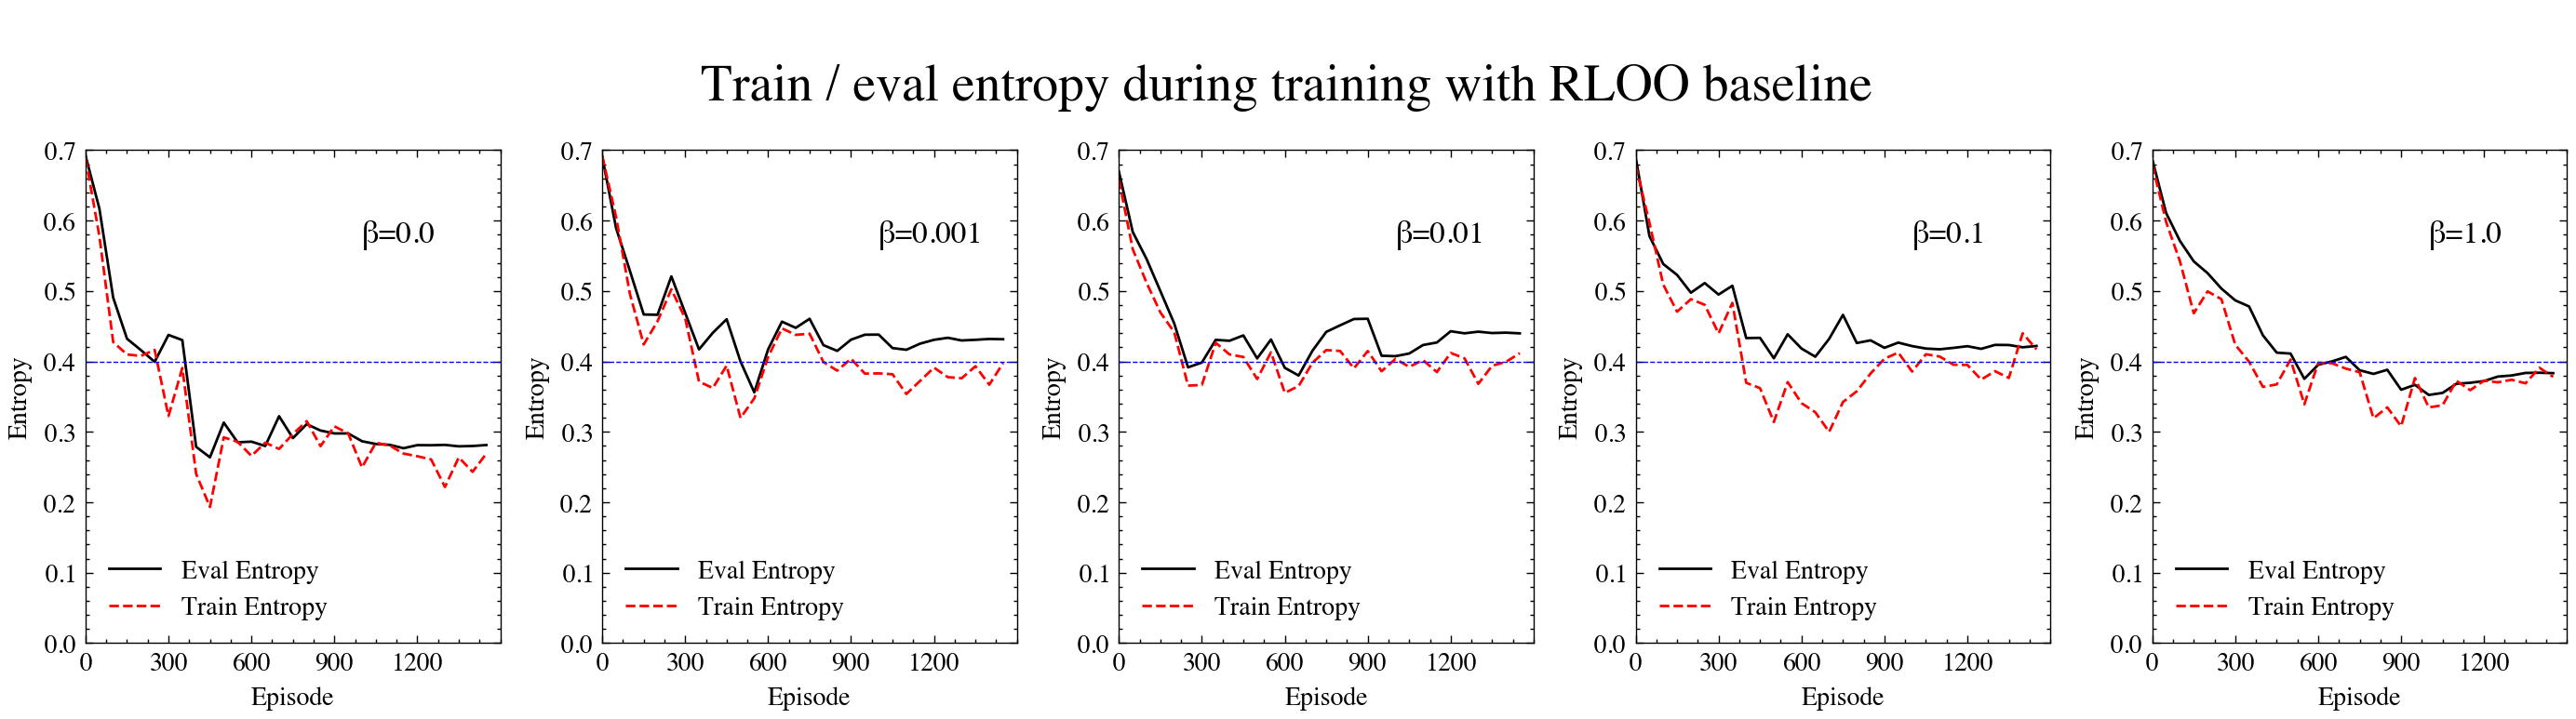

In [550]:
def show_rloo_baseline_entropy():
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,4))
    fig.suptitle('\nTrain / eval entropy during training with RLOO baseline', fontsize = 20)
    axs = axs.flatten()

    entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

    for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
        eval_entropy_steps, eval_entropy_values = rloo_eval_entropy['Step'], rloo_eval_entropy[entropy_coef]
        train_entropy_steps, train_entropy_values = rloo_train_entropy[rloo_train_entropy['Step'].isin(eval_entropy_steps)]['Step'], rloo_train_entropy[rloo_train_entropy['Step'].isin(eval_entropy_steps)][entropy_coef]

        ax.plot(eval_entropy_steps, eval_entropy_values, label='Eval Entropy')
        ax.plot(train_entropy_steps, train_entropy_values, label='Train Entropy')
        ax.axhline(y=0.4, color='blue', linestyle='--', linewidth=0.5)

        ax.set_xlabel('Episode', fontsize=10)
        ax.set_ylabel('Entropy', fontsize=10)

        ax.set_ylim([0.0, 0.7])
        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=8)

        ax.legend(prop={'size': 10})
        ax.text(1000, 0.57, f'β={beta}', fontsize=12)

        ax.tick_params(axis='both', which='major', labelsize=10)



    plt.tight_layout()
    plt.show()
show_rloo_baseline_entropy()

В RLOO при $\beta=0$ достигается наименьший уровень энтропии при (как показано ниже на графиках) стабильной сходимости.

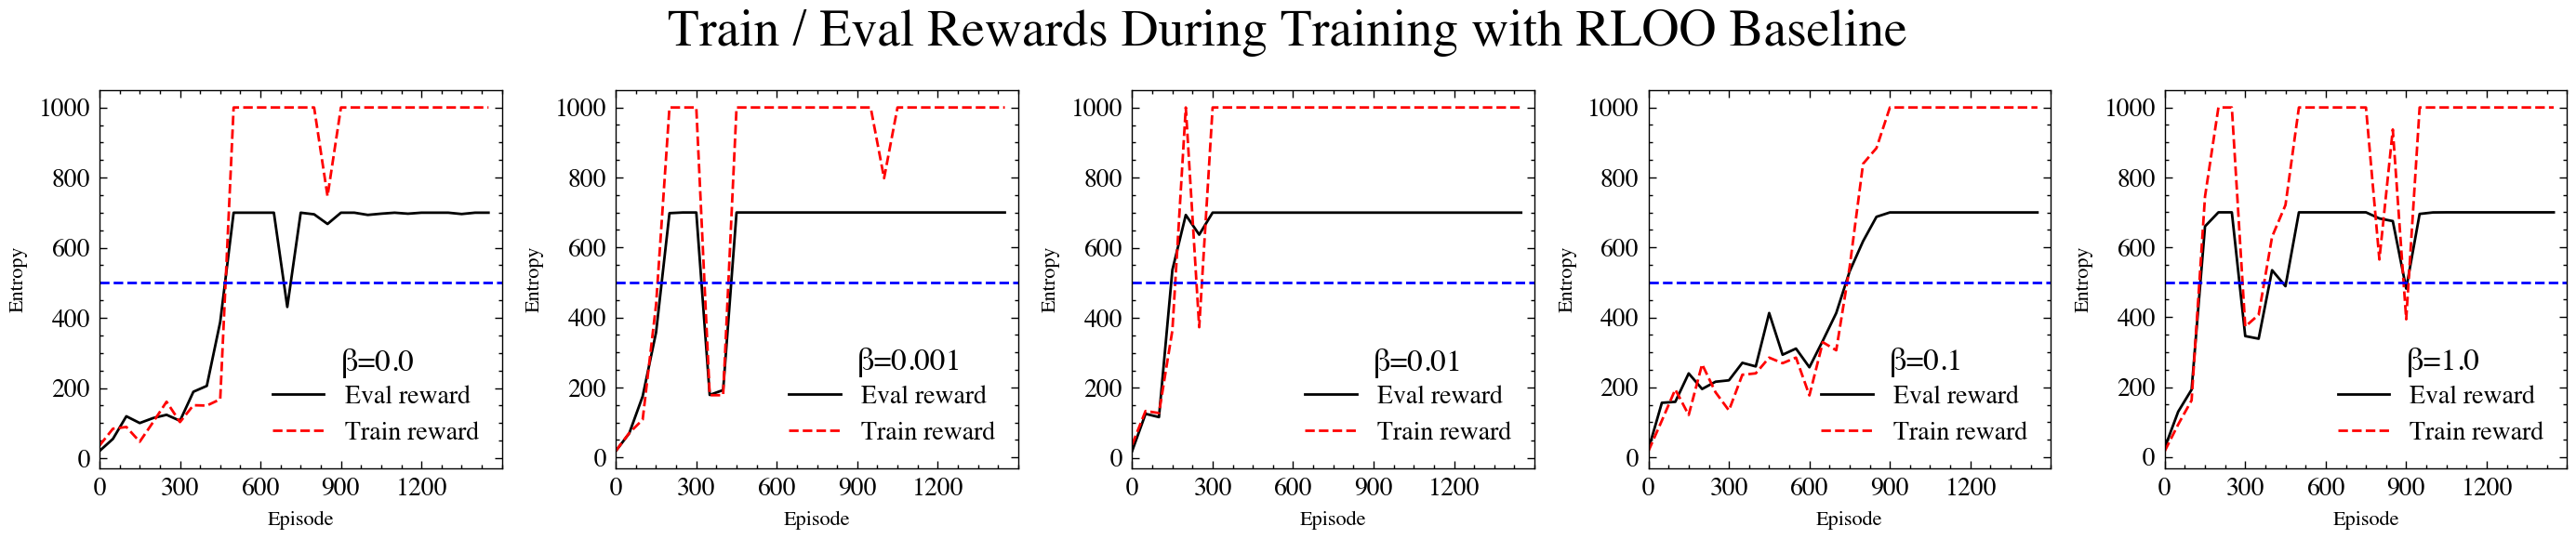

In [552]:
def draw_rloo_baseline_reward():

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,3))
    fig.suptitle('Train / Eval Rewards During Training with RLOO Baseline', fontsize = 20)
    axs = axs.flatten()
    axs = axs.flatten()

    entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

    for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
        eval_reward_steps = rloo_eval_reward['Step']
        eval_reward_values = rloo_eval_reward[entropy_coef]

        train_reward_steps = rloo_train_reward[rloo_train_reward['Step'].isin(eval_reward_steps)]['Step']
        train_reward_values = rloo_train_reward[rloo_train_reward['Step'].isin(eval_reward_steps)][entropy_coef]

        ax.plot(eval_reward_steps, eval_reward_values, label='Eval reward')
        ax.plot(train_reward_steps, train_reward_values, label='Train reward')
        ax.axhline(y=500, color='blue', linestyle='--', linewidth=1)

        ax.set_xlabel('Episode', fontsize=8)
        ax.set_ylabel('Entropy', fontsize=8)

        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.legend(prop={'size': 10}, loc='lower right')
        # ax.grid(True)
        ax.text(900, 250, f'β={beta}', fontsize=12)

    plt.tight_layout()
    plt.show()
draw_rloo_baseline_reward()

$RLOO$ требуется чуть больше времени, чтобы достичь наивысшей награды, однако он не требует настройки бейзлайн модели value-функции, таким образом сочетая в себе преимущества первого и второго подходов.

Ниже для демонстрации я выбрал одну из моделей



In [565]:
Video(filename='../data/video/cart_pole-vf-stable.mp4', height=320, width=480)

Video(value=b'', height='320', width='480')

### Behavioral Cloning

#### Сетап экспериментов

В качестве учителя была выбрана одна из моделей, среди обученных на предыдущем шаге ($\text{REINFORCE}$ с Value-Function бейзлайном $\beta=1.0$). Для генерации пар state-action пар был выбран следующий подход. Взяты наборы $seeds_{eval}$, на основе них были запущены окружения и получены требуемые пары. Затем все пары были добавлены в общий датасет и перемешаны. Из датасетов было просемплировано $N = 1000$ пар. Обучение длилось 100 эпох, размер батча составлял $64$, шаг обучения $1e-3$. Для обучения использовался $CE$-loss.

Валидация модели производилась на двух наборах сидов. Первый набор сидов это те сиды ($seed \in [10.000, 10.100)$), из которых был просемлирован обучающий датасет, второй набор это новые сиды ($seed \in [100.000, 100.100)$), которые не использовались в том числе при обучении агента-учителя.

#### Результаты эксперимента

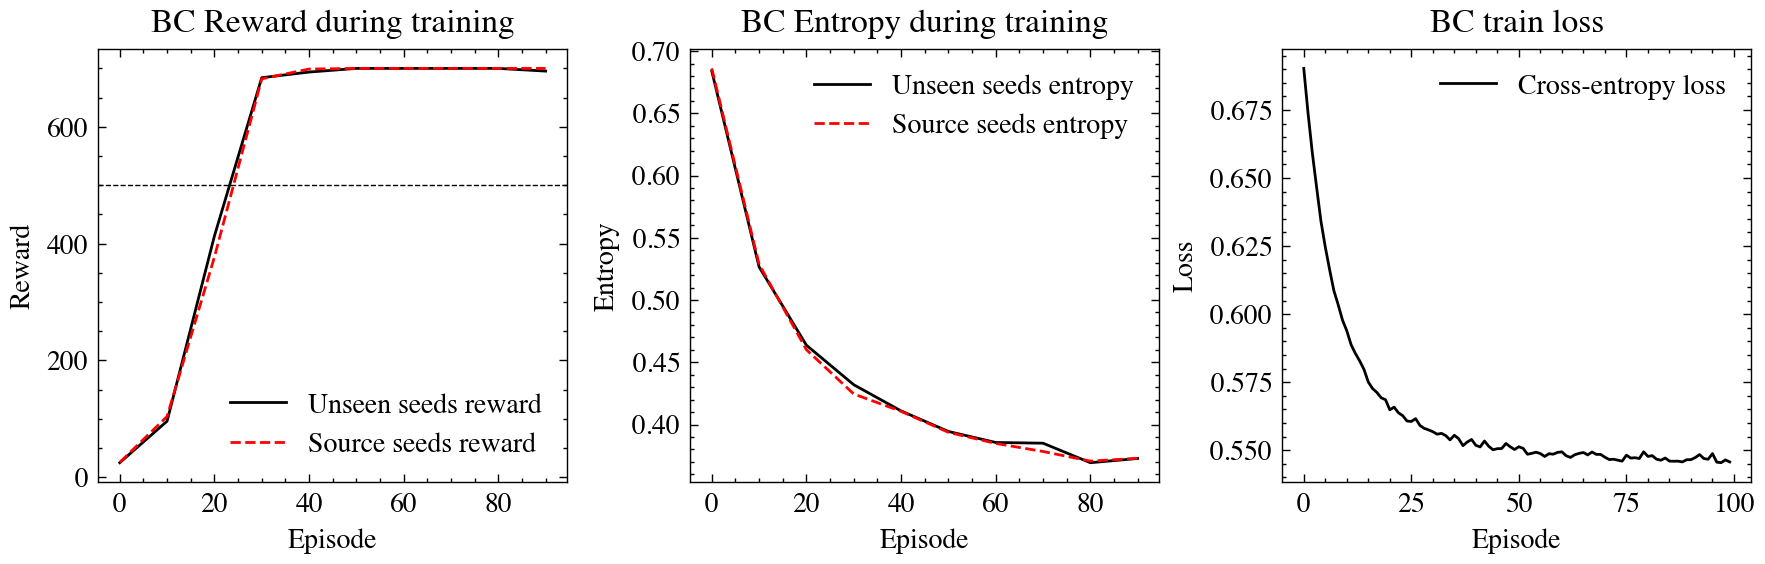

In [488]:
def draw_bc():
    bc_reward_df = pd.read_csv('../data/bc/reward.csv')
    bc_entropy_df = pd.read_csv('../data/bc/entropy.csv')
    bc_loss_df = pd.read_csv('../data/bc/loss.csv')

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
    axs = axs.flatten()

    axs[0].plot(bc_reward_df['Step'], bc_reward_df['val/avg_episode_reward'], label='Unseen seeds reward')
    axs[0].plot(bc_reward_df['Step'], bc_reward_df['val/source/avg_episode_reward'], label='Source seeds reward')
    axs[0].axhline(y=500, linestyle='--', linewidth=0.5)
    axs[0].set_xlabel('Episode', fontsize=10)
    axs[0].set_ylabel('Reward', fontsize=10)
    axs[0].tick_params(axis='both', labelsize=10)
    axs[0].set_title('BC Reward during training', fontsize=12)
    axs[0].legend(prop={'size': 10})

    axs[1].plot(bc_entropy_df['Step'], bc_entropy_df['val/avg_episode_entropy'], label='Unseen seeds entropy')
    axs[1].plot(bc_entropy_df['Step'], bc_entropy_df['val/source/avg_episode_entropy'], label='Source seeds entropy')
    axs[1].set_xlabel('Episode', fontsize=10)
    axs[1].set_ylabel('Entropy', fontsize=10)
    axs[1].tick_params(axis='both', labelsize=10)
    axs[1].set_title('BC Entropy during training', fontsize=12)
    axs[1].legend(prop={'size': 10})

    axs[2].plot(bc_loss_df['Step'], bc_loss_df['loss'], label='Cross-entropy loss')
    axs[2].set_xlabel('Episode', fontsize=10)
    axs[2].set_ylabel('Loss', fontsize=10)
    axs[2].tick_params(axis='both', labelsize=10)
    axs[2].set_title('BC train loss', fontsize=12)
    axs[2].legend(prop={'size': 10})

    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
draw_bc()

На основе семплов из траекторий учителя удалось обучить ученика при помощи кросс-энтропийного лосса. Политика-ученик смогла выбить максимальную награду на обоих наборах сидов спустя 50 эпох (фактически скорее раньше, просто валидация осуществлялась каждые 50 шагов).

#### Поведение политики в неизвестных состояниях

Одним из недостатков подхода $\text{Behavioral Cloning}$ является тот факт, что агент, попадающий в состояние, которого не было в обучающей выборке может начать вести себя непредсказуемо. Давайте возьмем политику $\pi_{teacher}$ и посмотрим на распределения параметров скорости/положения/угловой скорости/угла отклонения от вертикальной оси.

In [ ]:
states = np.loadtxt('../data/states.txt')

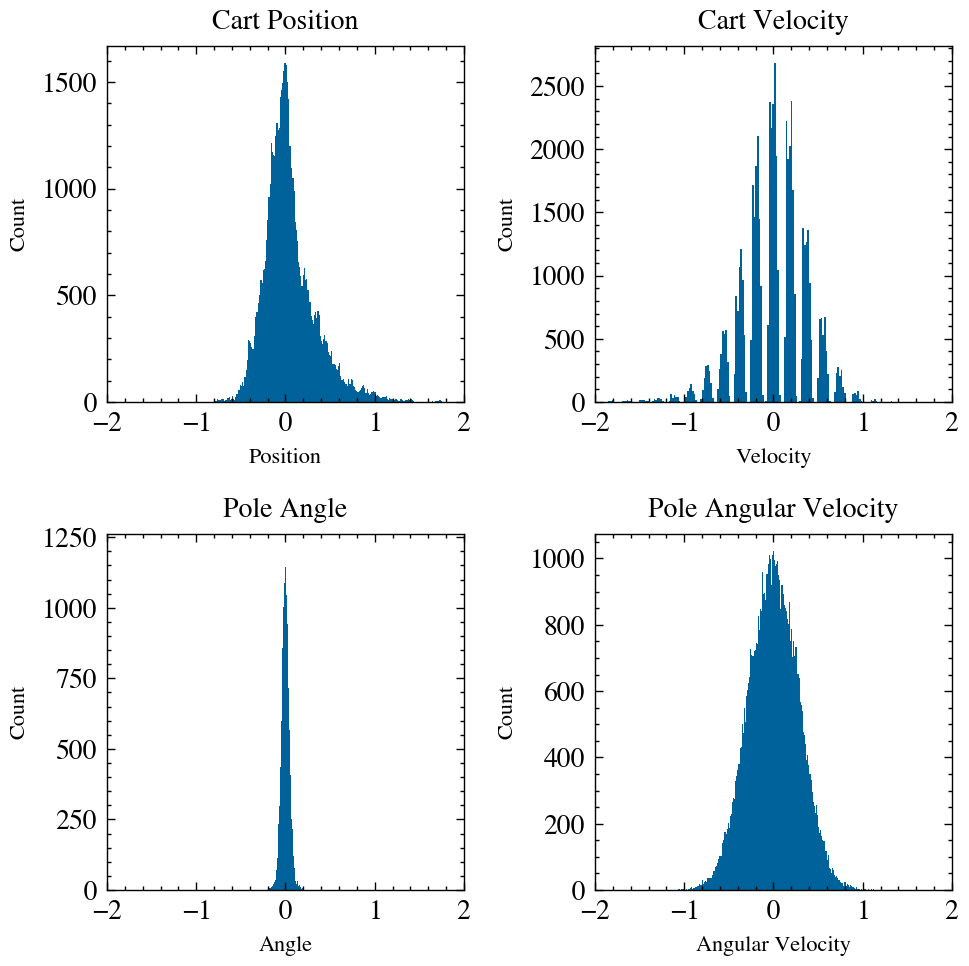

In [521]:
def draw_states(s, color:str='#00629B'):
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    fig.subplots_adjust(hspace=0.5)

    axs = axs.flatten()

    plot_properties = [
        ('Cart Position', [-2, 2], 'Position'),
        ('Cart Velocity', (-2, 2), 'Velocity'),
        ('Pole Angle', (-0.3, 0.3), 'Angle'),
        ('Pole Angular Velocity', (-2, 2), 'Angular Velocity'),
    ]

    for i, ax in enumerate(axs):
        ax.hist(s[:, i], bins=200, color=color)
        ax.set_title(plot_properties[i][0], fontsize=10)
        ax.set_xlim(-2, 2)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_ylabel('Count', fontsize=8)
        ax.set_xlabel(plot_properties[i][2], fontsize=8)

    fig.tight_layout()
draw_states(states)

В качестве экперимента я убрал часть семплов для параметра $Position$, значения которого выходят за пределы $(-1, +1)$

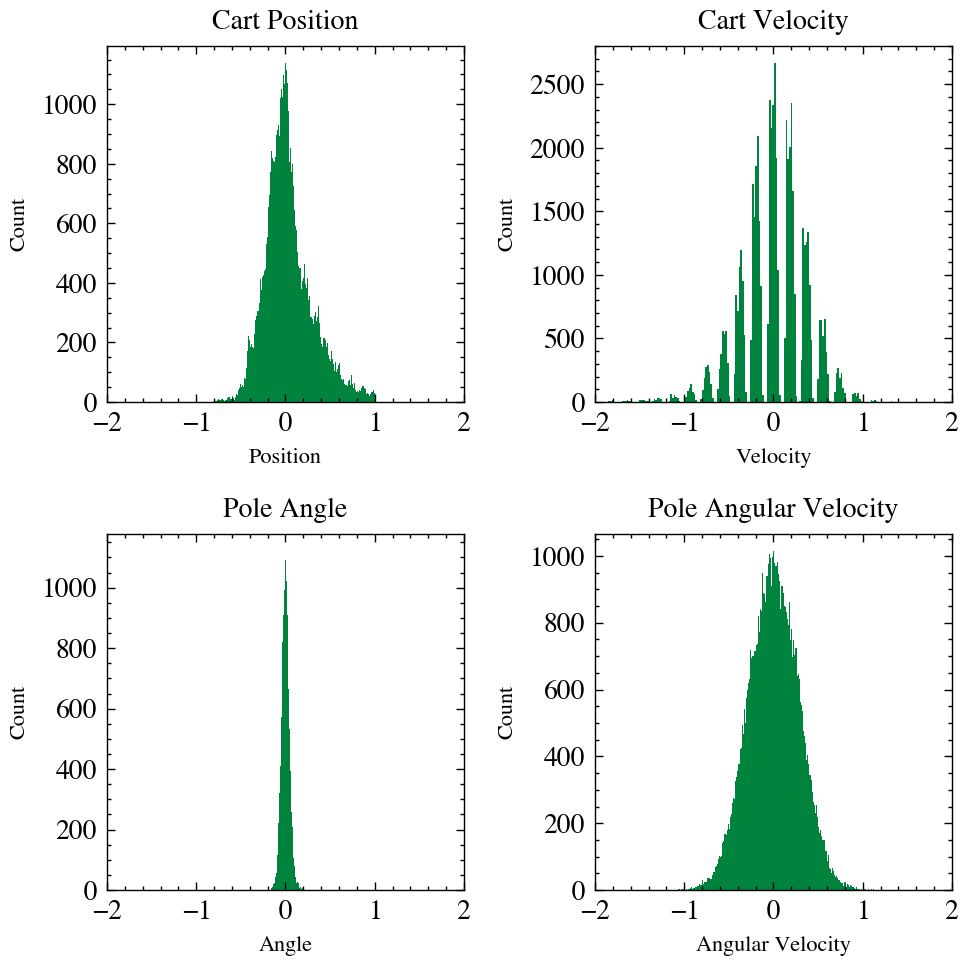

In [523]:
filtered_states = []
for state in states:
    position = state[0]
    if (position < 1.0) and (position > -1.0):
        filtered_states.append(state)
filtered_states = np.array(filtered_states)
draw_states(filtered_states, color='#00843D')

Гиперпараметры при обучении остались такими же, как и в случае простого $BC$

In [569]:
bc_min_rewards_df = pd.read_csv('../data/bc/bc_min_reward.csv')
bc_min_rewards_stateless_df = pd.read_csv('../data/bc/bc_min_reward_stateless.csv')

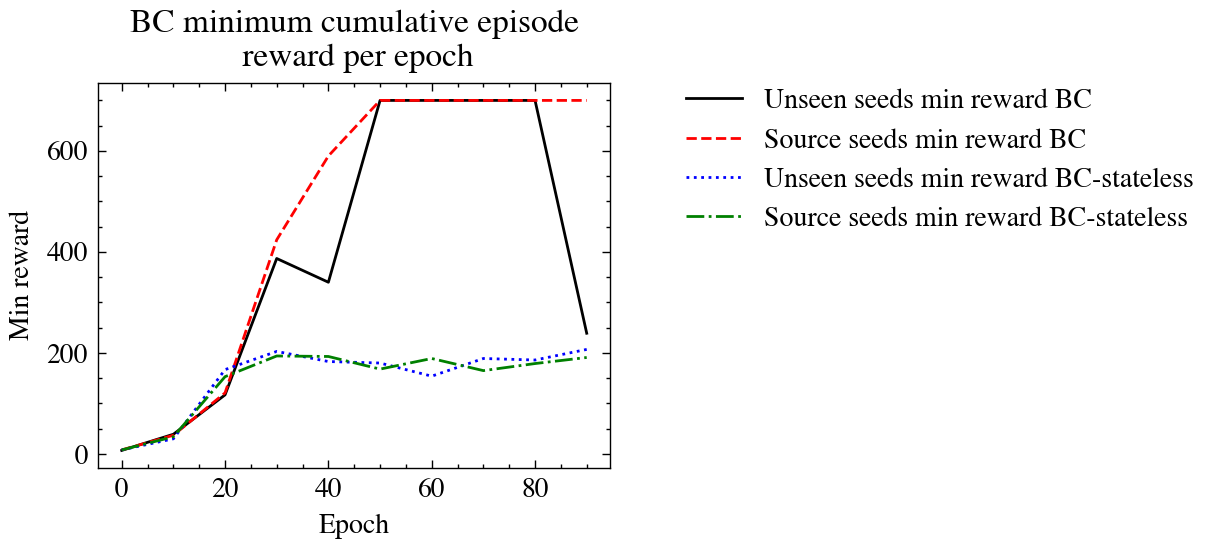

In [592]:
steps = bc_min_rewards_df['Step']

plt.plot(steps, bc_min_rewards_df['val/min_episode_reward'], label='Unseen seeds min reward BC')
plt.plot(steps, bc_min_rewards_df['val/source/min_episode_reward'], label='Source seeds min reward BC')

plt.plot(steps, bc_min_rewards_stateless_df['val/min_episode_reward'], label='Unseen seeds min reward BC-stateless')
plt.plot(steps, bc_min_rewards_stateless_df['val/source/min_episode_reward'], label='Source seeds min reward BC-stateless')

plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Min reward', fontsize=10)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('BC minimum cumulative episode\n reward per epoch', fontsize=12)
plt.legend(bbox_to_anchor=(1.1, 1.05), prop={'size': 10})
plt.tight_layout()
plt.show()

При выкидывании части состояний появляются эпизоды, в которых агент не может преодалеть требуемый порог награды. При этом качество агента в среднем деградирует не сильно (средняя награда на графике ниже).

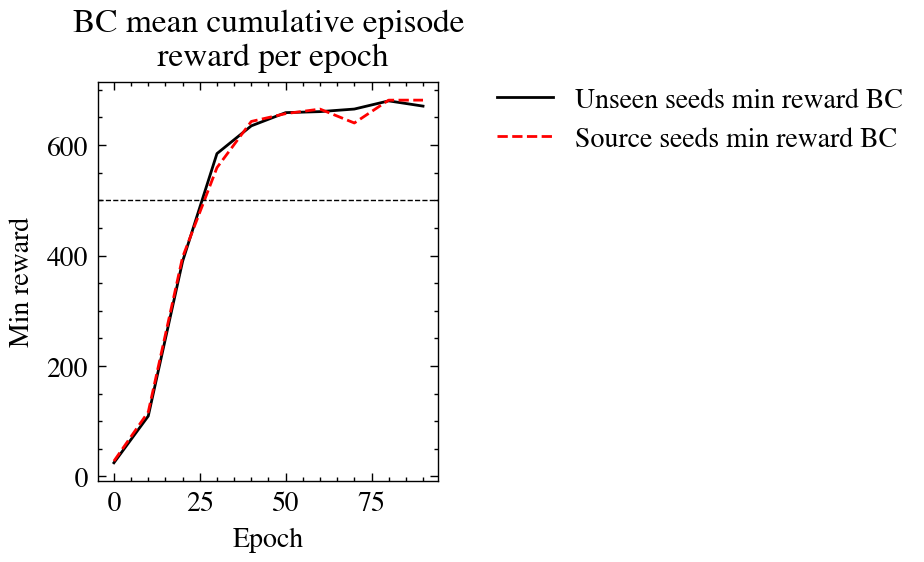

In [602]:
plt.figure(figsize=(5, 3))

bc_avg_reward = pd.read_csv('../data/bc/bc_avg_reward.csv')

plt.plot(steps, bc_avg_reward['val/avg_episode_reward'], label='Unseen seeds min reward BC')
plt.plot(steps, bc_avg_reward['val/source/avg_episode_reward'], label='Source seeds min reward BC')
plt.axhline(y=500, linestyle='--', linewidth=0.5)

plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Min reward', fontsize=10)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('BC mean cumulative episode\n reward per epoch', fontsize=12)
plt.legend(bbox_to_anchor=(1.1, 1.05), prop={'size': 10})
plt.tight_layout()
plt.show()

Таким образом мы пронаблюдали проблему "слепых зон" в пространстве состояний для модели обученный по принципу клонирования поведения.